In [46]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Imports

In [484]:
import sys
import os
import torch  
from torchsummary import summary 
from torch import nn
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
import numpy as np 
import cv2  
import pydicom
from skimage import io 
import matplotlib.pyplot as plt
from collections import OrderedDict, defaultdict

In [485]:
sys.path.append('/Users/sandradening/Desktop/SU/Coding/vlm-seminar/')
sys.path.append('/Users/sandradening/Desktop/SU/Coding/vlm-seminar/Finetune')

In [486]:
# Add MedCLIP folder to path
project_root = os.path.abspath(os.path.join(os.getcwd(), '..', 'MedCLIP'))
if project_root not in sys.path:
    sys.path.append(project_root)

In [487]:
notebook_path = os.getcwd()
sys.path.append(os.path.abspath(os.path.join(notebook_path, '../..')))

In [488]:
import medclip
print(medclip.__file__) #verify if worked

/Users/sandradening/Desktop/SU/Coding/vlm-seminar/MedCLIP/medclip/__init__.py


In [504]:
from medclip.modeling_medclip import MedCLIPVisionModelViT, MedCLIPModel
#from MedCLIP.medclip.modeling_medclip import MedCLIPVisionModelViT
from medclip.dataset import SuperviseImageCollator 
from medclip.modeling_medclip import SuperviseClassifier
from medclip.losses import ImageSuperviseLoss
from medclip.evaluator import Evaluator

## Import Classes

In [490]:
class GradCam:
    def __init__(self, model, target):
        self.model = model.eval()  # Set the model to evaluation mode
        self.feature = None  # To store the features from the target layer
        self.gradient = None  # To store the gradients from the target layer
        self.handlers = []  # List to keep track of hooks
        self.target = target  # Target layer for Grad-CAM
        self._get_hook()  # Register hooks to the target layer

    # Hook to get features from the forward pass
    def _get_features_hook(self, module, input, output):
        self.feature = self.reshape_transform(output)  # Store and reshape the output features

    # Hook to get gradients from the backward pass
    def _get_grads_hook(self, module, input_grad, output_grad):
        self.gradient = self.reshape_transform(output_grad)  # Store and reshape the output gradients

        def _store_grad(grad):
            self.gradient = self.reshape_transform(grad)  # Store gradients for later use

        output_grad.register_hook(_store_grad)  # Register hook to store gradients

    # Register forward hooks to the target layer
    def _get_hook(self):
        self.target.register_forward_hook(self._get_features_hook)
        self.target.register_forward_hook(self._get_grads_hook)

    def reshape_transform(self, tensor, height=7, width=7): #adapted
        result = tensor.reshape(tensor.size(0), height, width, tensor.size(2))
        result = result.transpose(1, 2).transpose(1, 3)  # (B, C, H, W)
        return result

    # Function to compute the Grad-CAM heatmap
    def __call__(self, inputs):
        self.model.zero_grad()  # Zero the gradients
        print(f"[DEBUG] Input shape: {inputs.shape}")
        output = self.model(pixel_values=inputs)

        # Get the index of the highest score in the output
        index = np.argmax(output.cpu().data.numpy())
        target = output[0][index]  # Get the target score
        target.backward()  # Backward pass to compute gradients

        # Get the gradients and features
        gradient = self.gradient[0].cpu().data.numpy()
        weight = np.mean(gradient, axis=(1, 2))  # Average the gradients
        feature = self.feature[0].cpu().data.numpy()

        # Compute the weighted sum of the features
        cam = feature * weight[:, np.newaxis, np.newaxis]
        cam = np.sum(cam, axis=0)  # Sum over the channels
        cam = np.maximum(cam, 0)  # Apply ReLU to remove negative values

        # Normalize the heatmap
        cam -= np.min(cam)
        cam /= np.max(cam)
        cam = cv2.resize(cam, (224, 224))  # Resize to match the input image size
        return cam  # Return the Grad-CAM heatmap

In [491]:
class DICOMImageDataset(Dataset):
    def __init__(self, dicom_path, label: int):
        self.dicom_path = dicom_path
        self.label = label

        self.means = [0.5863]
        self.stds = [0.2795]

        # Resize + normalize to match model input
        self.transform = transforms.Compose([
            transforms.ToPILImage(),
            transforms.Resize((224, 224)),
            transforms.ToTensor(),  # Converts to [0, 1] and CHW
            transforms.Normalize(mean=self.means, std=self.stds),
        ])

    def __len__(self):
        return 1

    def __getitem__(self, idx):
        dicom = pydicom.dcmread(self.dicom_path)
        img = dicom.pixel_array.astype(np.float32)

        # Convert grayscale to 3-channel
        if len(img.shape) == 2:
            img = np.stack([img]*3, axis=-1)

        # Scale to [0, 255] and convert to uint8 for PIL
        img = cv2.convertScaleAbs(img, alpha=(255.0 / np.max(img)))

        img = self.transform(img)  # (3, 224, 224)
        return img, torch.tensor([self.label])

In [492]:
class SuperviseClassifier(nn.Module):
    '''Take MedCLIP model with linear heads for supervised classification on images.'''

    def __init__(self, vision_model, num_class=14, input_dim=512, mode=None, device=None, **kwargs):
        """
        Args:
            vision_model: The MedCLIP vision model.
            num_class: Number of classes to predict.
            input_dim: The embedding dimension output by the vision model.
            mode: Classification mode ('multiclass', 'multilabel', 'binary').
            device: The device to use (CPU/GPU).
        """
        super().__init__()
        self.model = vision_model
        self.num_class = num_class
        self.mode = mode.lower()
        self.device = device or torch.device("cpu")

        # Define the output layer
        if num_class > 2:
            if mode == 'multiclass':
                self.loss_fn = nn.CrossEntropyLoss()
            else:
                self.loss_fn = nn.BCEWithLogitsLoss()

            self.fc = nn.Linear(input_dim, num_class)  # Match input_dim
        else:
            self.loss_fn = nn.BCEWithLogitsLoss()
            print("Binary loss is used.")
            self.fc = nn.Linear(input_dim, 1)  # Match input_dim

    def forward(self, pixel_values, labels=None, return_loss=True, **kwargs):
        outputs = defaultdict()

        vision_output = self.model(pixel_values=pixel_values, project=False)

        if isinstance(vision_output, dict):
            #print("Vision model output keys:", vision_output.keys())
            if 'img_embeds' in vision_output:
                img_embeds = vision_output['img_embeds']
            else:
                raise ValueError(
                    f"The vision model output does not contain 'img_embeds'. "
                    f"Available keys: {vision_output.keys()}"
                )
        else:
            img_embeds = vision_output

        logits = self.fc(img_embeds)
        outputs['embedding'] = img_embeds
        outputs['logits'] = logits

        if labels is not None and return_loss:
            labels = labels.float()
            if len(labels.shape) == 1:
                labels = labels.view(-1, 1)
            #labels = labels.float()  # Reshape to [32, 1] to match logits
            #print(f"Logits: {logits.detach().cpu().numpy()}")  # Print logits
            #print(f"Labels: {labels.detach().cpu().numpy()}")  # Print labels
            loss = self.loss_fn(logits, labels)
            #print(f"Loss value: {loss.item()}") 
            outputs['loss_value'] = loss

        return outputs

In [493]:
#custom for single image
class SingleImageDataset(Dataset):
    def __init__(self, image_path):
        self.image_path = image_path
        self.means = np.array([0.5863, 0.5863, 0.5863])
        self.stds = np.array([0.2795, 0.2795, 0.2795])

    def __len__(self):
        return 1

    def __getitem__(self, idx):
        img = cv2.imread(self.image_path)
        img = cv2.resize(img, (224, 224))
        img = img[:, :, :3]  # drop alpha if needed
        img = img.astype(np.float32) / 255.0
        img = (img - self.means) / self.stds
        img = np.transpose(img, (2, 0, 1))  # HWC to CHW
        tensor_img = torch.tensor(img).float()
        dummy_label = torch.tensor([0])  # dummy label; unused in test --> change later

        return tensor_img, dummy_label

## Import Functions

In [494]:
# Function to prepare input image for the model
def prepare_input(image):
    image = image.copy() 

    # Normalize the image using the mean and standard deviation
    means = np.array([0.5863, 0.5863, 0.5863])
    stds = np.array([0.2795, 0.2795, 0.2795])
    image -= means
    image /= stds

    # Transpose the image to match the model's expected input format (C, H, W)
    image = np.ascontiguousarray(np.transpose(image, (2, 0, 1)))
    image = image[np.newaxis, ...]  # Add batch dimension

    return torch.tensor(image, requires_grad=True)  # Convert to PyTorch tensor

In [495]:
# Function to generate a Grad-CAM heatmap
def gen_cam(image, mask):
    # Create a heatmap from the Grad-CAM mask
    heatmap = cv2.applyColorMap(np.uint8(255 * (1 - mask)), cv2.COLORMAP_JET)
    heatmap = np.float32(heatmap) / 255

    # Superimpose the heatmap on the original image
    cam = (1 - 0.5) * heatmap + 0.5 * image
    cam = cam / np.max(cam)  # Normalize the result
    return np.uint8(255 * cam)  # Convert to 8-bit image

In [496]:
#plot some images
def show_image(path, bbox=None, title=""):
    ds = pydicom.dcmread(path)
    plt.imshow(ds.pixel_array, cmap='gray')
    if bbox:
        if isinstance(bbox[0], list):  # multiple boxes
            for b in bbox:
                x1, y1, x2, y2 = b
                w, h = x2 - x1, y2 - y1
                rect = plt.Rectangle((x1, y1), w, h, edgecolor='r', facecolor='none')
                plt.gca().add_patch(rect)
        else:  # single box
            x1, y1, x2, y2 = bbox
            w, h = x2 - x1, y2 - y1
            rect = plt.Rectangle((x1, y1), w, h, edgecolor='r', facecolor='none')
            plt.gca().add_patch(rect)
    plt.title(title)
    plt.axis('off')

In [497]:
#dicom_path = "5d8dbcf9-0d68-4aec-8638-b0a9f45d71d6.dcm"
#dicom_path = "0edcf2dd-71fe-4108-9303-24d51b4faf72.dcm" 
dicom_path = "8d1a4fe3-329f-4eea-a5b7-953d617a74fa.dcm" #used for analyssis
#dicom_path = "d58012a2-a845-472d-8f49-336a3cc977c1.dcm"
#dicom_path = "b0604ee6-5f21-4b14-98ca-3bedaccd4e10.dcm"
#dicom_path = "5b3477db-9494-4617-acac-e2f28452ebb0.dcm"

true_label = 1 

bbox = [[189.0, 147.0, 467.0, 649.0], [572.0, 164.0, 818.0, 590.0]]
#bbox = [[186.0, 421.0, 369.0, 609.0], [612.0, 549.0, 747.0, 741.0]]
#bbox = [[0.0, 0.0, 0.0, 0.0]]

dicom_dataset = DICOMImageDataset(dicom_path, label=true_label)

dicom_loader = DataLoader(
    dicom_dataset,
    batch_size=1,
    collate_fn=SuperviseImageCollator(mode="binary"),
    shuffle=False,
    num_workers=0
)

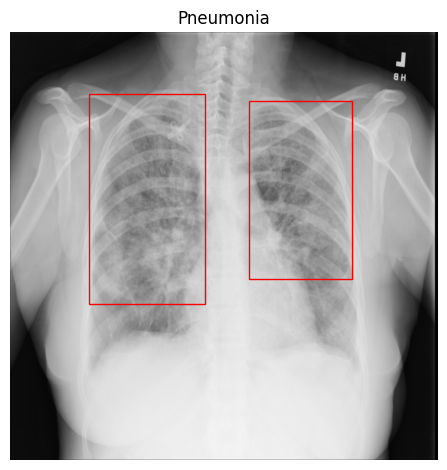

In [498]:
show_image(dicom_path, bbox=bbox, title='Pneumonia')

plt.tight_layout()
plt.show()

In [499]:
#main
# Load and preprocess the input image
img = io.imread("both.png")
img = np.float32(cv2.resize(img, (224, 224))) / 255  # Resize and normalize
if img.shape[-1] == 4:  # Check for RGBA
    img = img[:, :, :3]
inputs = prepare_input(img) 

In [500]:
inputs

tensor([[[[1.4801, 1.4801, 1.4801,  ..., 1.4801, 1.4801, 1.4801],
          [1.4801, 1.4801, 1.4801,  ..., 1.4801, 1.4801, 1.4801],
          [1.4801, 1.4801, 1.4801,  ..., 1.4801, 1.4801, 1.4801],
          ...,
          [1.4801, 1.4801, 1.4801,  ..., 1.4801, 1.4801, 1.4801],
          [1.4801, 1.4801, 1.4801,  ..., 1.4801, 1.4801, 1.4801],
          [1.4801, 1.4801, 1.4801,  ..., 1.4801, 1.4801, 1.4801]],

         [[1.4801, 1.4801, 1.4801,  ..., 1.4801, 1.4801, 1.4801],
          [1.4801, 1.4801, 1.4801,  ..., 1.4801, 1.4801, 1.4801],
          [1.4801, 1.4801, 1.4801,  ..., 1.4801, 1.4801, 1.4801],
          ...,
          [1.4801, 1.4801, 1.4801,  ..., 1.4801, 1.4801, 1.4801],
          [1.4801, 1.4801, 1.4801,  ..., 1.4801, 1.4801, 1.4801],
          [1.4801, 1.4801, 1.4801,  ..., 1.4801, 1.4801, 1.4801]],

         [[1.4801, 1.4801, 1.4801,  ..., 1.4801, 1.4801, 1.4801],
          [1.4801, 1.4801, 1.4801,  ..., 1.4801, 1.4801, 1.4801],
          [1.4801, 1.4801, 1.4801,  ..., 1

In [501]:
#final_model_path = '../MedCLIP/checkpoints/rsna_binary_classification_SU_balanced/epoch_15/pytorch_model.bin' 
#final_model_path = '../MedCLIP/checkpoints/rsna_binary_classification_SU/epoch_15/pytorch_model.bin' 
final_model_path = '../MedCLIP/checkpoints/rsna_binary_classification_SU_weightedLoss/epoch_15/pytorch_model.bin' 
print(f"Loading the final model from {final_model_path}")

Loading the final model from ../MedCLIP/checkpoints/rsna_binary_classification_SU_weightedLoss/epoch_15/pytorch_model.bin


In [505]:
device = torch.device("cpu")
model = MedCLIPModel(vision_cls=MedCLIPVisionModelViT, device=torch.device("cpu")) #use ViT #use CPU
model.to(device)

/Users/sandradening/anaconda3/envs/Sandra_Coding/lib/python3.8/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


MedCLIPModel(
  (vision_model): MedCLIPVisionModelViT(
    (model): SwinModel(
      (embeddings): SwinEmbeddings(
        (patch_embeddings): SwinPatchEmbeddings(
          (projection): Conv2d(3, 96, kernel_size=(4, 4), stride=(4, 4))
        )
        (norm): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
        (dropout): Dropout(p=0.0, inplace=False)
      )
      (encoder): SwinEncoder(
        (layers): ModuleList(
          (0): SwinStage(
            (blocks): ModuleList(
              (0-1): 2 x SwinLayer(
                (layernorm_before): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
                (attention): SwinAttention(
                  (self): SwinSelfAttention(
                    (query): Linear(in_features=96, out_features=96, bias=True)
                    (key): Linear(in_features=96, out_features=96, bias=True)
                    (value): Linear(in_features=96, out_features=96, bias=True)
                    (dropout): Dropout(p=0.0, inplace=F

In [506]:
model.load_state_dict(torch.load(final_model_path, map_location=torch.device("cpu")))

<All keys matched successfully>

In [507]:
model.eval()

MedCLIPModel(
  (vision_model): MedCLIPVisionModelViT(
    (model): SwinModel(
      (embeddings): SwinEmbeddings(
        (patch_embeddings): SwinPatchEmbeddings(
          (projection): Conv2d(3, 96, kernel_size=(4, 4), stride=(4, 4))
        )
        (norm): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
        (dropout): Dropout(p=0.0, inplace=False)
      )
      (encoder): SwinEncoder(
        (layers): ModuleList(
          (0): SwinStage(
            (blocks): ModuleList(
              (0-1): 2 x SwinLayer(
                (layernorm_before): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
                (attention): SwinAttention(
                  (self): SwinSelfAttention(
                    (query): Linear(in_features=96, out_features=96, bias=True)
                    (key): Linear(in_features=96, out_features=96, bias=True)
                    (value): Linear(in_features=96, out_features=96, bias=True)
                    (dropout): Dropout(p=0.0, inplace=F

In [508]:
#resetup model to not mix up
model_clean = MedCLIPModel(vision_cls=MedCLIPVisionModelViT, device=torch.device("cpu"))
model_clean.load_state_dict(torch.load(final_model_path, map_location=torch.device("cpu")))
model_clean.eval()

# Redefine classifier using clean model
medclip_clf = SuperviseClassifier(
    vision_model=model_clean,
    num_class=1,
    input_dim=512,
    mode="binary",
    device=torch.device("cpu"),
)
medclip_clf.to(device)

# Now run newly setup model in evaluation
test_evaluator = Evaluator(
    medclip_clf=medclip_clf,
    eval_dataloader=single_image_loader,
    mode='binary'
)
#test_scores = test_evaluator.evaluate() 

Binary loss is used.


In [509]:
batch = next(iter(dicom_loader))
batch["pixel_values"].requires_grad_()

medclip_clf.eval()
with torch.enable_grad():
    logits = medclip_clf(pixel_values=batch["pixel_values"])["logits"]
    prob = torch.sigmoid(logits).item()
    pred = int(prob > 0.5)

In [510]:
logits

tensor([[-0.0266]], grad_fn=<AddmmBackward0>)

In [511]:
prob

0.4933597147464752

In [512]:
print(f"Prediction: {'Pneumonia' if pred else 'Healthy'}")
print(f"Confidence: {prob:.4f}, True label: {true_label}")

Prediction: Healthy
Confidence: 0.4934, True label: 1


In [513]:
model_clean.vision_model.model.encoder.layers[3].blocks[1].attention.output.dense

Linear(in_features=768, out_features=768, bias=True)

In [514]:
target_layer = model_clean.vision_model.model.encoder.layers[3].blocks[1].attention.output.dense #adapt layer of medlcip
grad_cam = GradCam(model_clean.vision_model, target=target_layer) #adapt for medclip

In [515]:
mask = grad_cam(inputs)  # Compute the Grad-CAM mask
result = gen_cam(img, mask)  # Generate the Grad-CAM heatmap

[DEBUG] Input shape: torch.Size([1, 3, 224, 224])


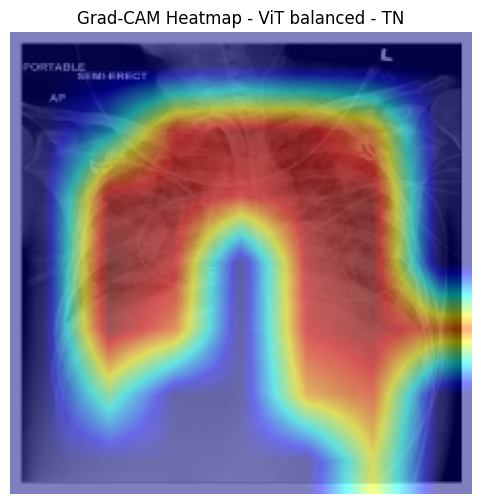

In [516]:
plt.figure(figsize=(6, 6))
plt.imshow(result)
plt.axis('off')
plt.title(f"Grad-CAM Heatmap - ViT balanced - TN")
plt.show()

## Deprecated version (no predicted labels were extracted with it!)

In [517]:
import sys
import os

# Add MedCLIP folder to path
project_root = os.path.abspath(os.path.join(os.getcwd(), '..', 'MedCLIP'))
if project_root not in sys.path:
    sys.path.append(project_root)

In [76]:
import medclip
print(medclip.__file__)

/Users/sandradening/Desktop/SU/Coding/vlm-seminar/MedCLIP/medclip/__init__.py


In [77]:
import os
import cv2
import torch
import numpy as np
import pydicom
import matplotlib.pyplot as plt
from PIL import Image
from torchvision import transforms
from medclip.modeling_medclip import MedCLIPVisionModelViT
from gradcam import GradCam  # custom class

In [78]:
samples = [
    {"path": "../../datasets/rsna/stage_2_train_images/5b3477db-9494-4617-acac-e2f28452ebb0.dcm", "label": 0, "bbox": []},
    {"path": "../../datasets/rsna/stage_2_train_images/b6ebfc38-240b-4fac-ad09-ab378414fb55.dcm", "label": 1, "bbox": [[237.0, 639.0, 500.0, 836.0], [665.0, 631.0, 882.0, 785.0]]},
    {"path": "../../datasets/rsna/stage_2_train_images/153b7c2b-4909-4dca-8579-9523582bc4fe.dcm", "label": 0, "bbox": []},
    {"path": "../../datasets/rsna/stage_2_train_images/1a7606e0-4d81-4bbe-ae22-93ca30540cb9.dcm", "label": 1, "bbox": [[550.0, 451.0, 705.0, 599.0]]},
    {"path": "../../datasets/rsna/stage_2_train_images/f2698fda-0477-435f-b297-f1b284a731aa.dcm", "label": 0, "bbox": [[0.0, 0.0, 0.0, 0.0]]},
    {"path": "../../datasets/rsna/stage_2_train_images/b76dd4b8-7b51-4cb6-8fd7-0b7365ef3e1e.dcm", "label": 0, "bbox": [[0.0, 0.0, 0.0, 0.0]]},
    {"path": "../../datasets/rsna/stage_2_train_images/5d8dbcf9-0d68-4aec-8638-b0a9f45d71d6.dcm", "label": 1, "bbox": [[605.0, 435.0, 808.0, 616.0]]},
    {"path": "../../datasets/rsna/stage_2_train_images/39dc2e50-46a1-409e-ad59-98c33d300f2a.dcm", "label": 0, "bbox": [[0.0, 0.0, 0.0, 0.0]]},
    {"path": "../../datasets/rsna/stage_2_train_images/b8a2e49e-c1fc-4a78-96dd-0ee4f835eaaa.dcm", "label": 1, "bbox": [[588.0, 75.0, 857.0, 783.0], [205.0, 75.0, 478.0, 650.0]]},
    {"path": "../../datasets/rsna/stage_2_train_images/aa886a54-00d6-4f04-91b8-498c5c1bbc65.dcm", "label": 0, "bbox": [[0.0, 0.0, 0.0, 0.0]]},
    {"path": "../../datasets/rsna/stage_2_train_images/2d5d4cc5-5633-4718-ac7a-61bd0c7dbf4f.dcm", "label": 1, "bbox": [[292.0, 370.0, 396.0, 456.0]]},
    {"path": "../../datasets/rsna/stage_2_train_images/0edcf2dd-71fe-4108-9303-24d51b4faf72.dcm", "label": 1, "bbox": [[186.0, 421.0, 369.0, 609.0], [612.0, 549.0, 747.0, 741.0]]},
]

In [79]:
def plot_heatmaps(samples, checkpoint_path, method):

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    vision_model = MedCLIPVisionModelViT()
    state_dict = torch.load(checkpoint_path, map_location="cpu")

    vision_state_dict = {
        k.replace("vision_model.", ""): v
        for k, v in state_dict.items()
        if k.startswith("vision_model.")
    }
    vision_model.load_state_dict(vision_state_dict)
    vision_model.to(device).eval()

    target_layer = vision_model.model.encoder.layers[3].blocks[1].attention.output.dense
    grad_cam = GradCam(vision_model, target=target_layer)

    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5862785803043838], std=[0.27950088968644304]),
    ])
    
    #loop
    for idx, sample in enumerate(samples):
        print(f"Processing sample #{idx}")
        dicom_path = sample["path"]
        label = sample["label"]
        bbox_list = sample["bbox"]

        # --- Load DICOM image ---
        ds = pydicom.dcmread(dicom_path)
        image_np = ds.pixel_array.astype(np.float32)
        image_np = (image_np - image_np.min()) / (image_np.max() - image_np.min())
        image = Image.fromarray((image_np * 255).astype(np.uint8)).convert("L").convert("RGB")

        # --- Preprocess + forward ---
        input_tensor = transform(image).unsqueeze(0).to(device)
        input_tensor.requires_grad_()
        cam = grad_cam(input_tensor)  # shape: [224, 224]

        # --- Resize and overlay CAM on grayscale image ---
        image_gray = np.uint8(255 * image_np)
        image_resized = cv2.resize(image_gray, (224, 224))
        image_rgb = cv2.cvtColor(image_resized, cv2.COLOR_GRAY2RGB)

        #cam_normalized = (cam - cam.min()) / (cam.max() - cam.min())
        cam_normalized = 1.0 - (cam - cam.min()) / (cam.max() - cam.min())  
        #print("Max cam value location:", np.unravel_index(np.argmax(cam_normalized), cam_normalized.shape))
        cam_uint8 = np.uint8(255 * cam_normalized)
        heatmap = cv2.applyColorMap(cam_uint8, cv2.COLORMAP_JET)  # red = high

        overlay = cv2.addWeighted(image_rgb, 0.5, heatmap, 0.5, 0)

        # --- Optional: plot bounding boxes ---
        if label == 1 and bbox_list:
            scale_x = 224 / ds.Columns
            scale_y = 224 / ds.Rows
            for box in bbox_list:
                x1, y1, x2, y2 = [int(coord) for coord in box]
                x1, y1 = int(x1 * scale_x), int(y1 * scale_y)
                x2, y2 = int(x2 * scale_x), int(y2 * scale_y)
                cv2.rectangle(overlay, (x1, y1), (x2, y2), color=(0, 255, 0), thickness=2)

        # --- Show ---
        plt.figure(figsize=(5, 5))
        label_str = "Pneumonia" if label == 1 else "Healthy"
        #plt.title(f"Label: {label} ({label_str})")
        plt.title(f"#{idx} | {method} | Label: {'Pneumonia' if label == 1 else 'Healthy'}")

        plt.imshow(overlay)
        plt.axis("off")
        if idx in [0, 3, 8, 11]:
            plt.savefig(f"sample_{idx}_label_{label}_{method}.png")
        plt.show()

Processing sample #0


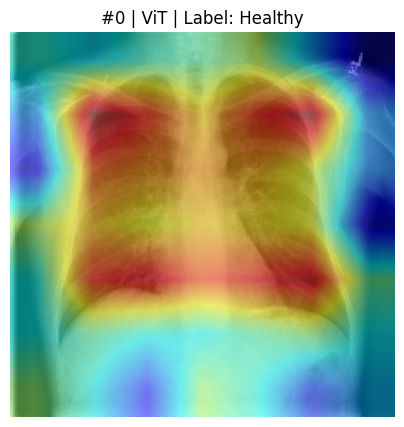

Processing sample #1


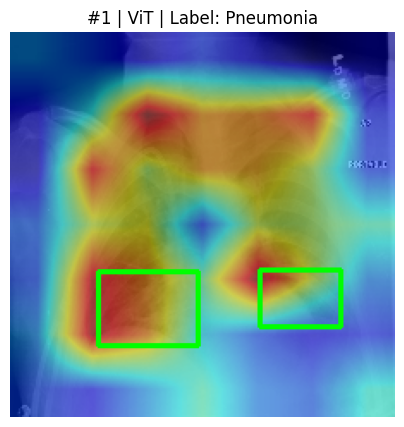

Processing sample #2


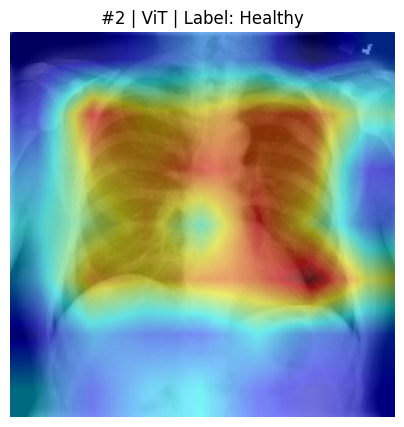

Processing sample #3


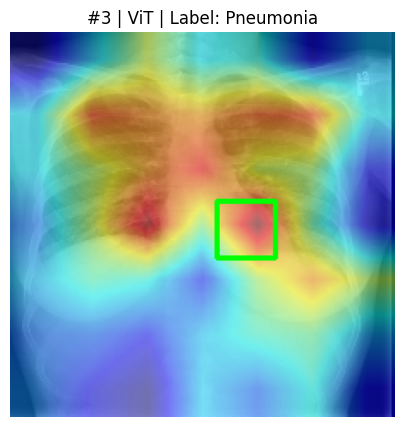

Processing sample #4


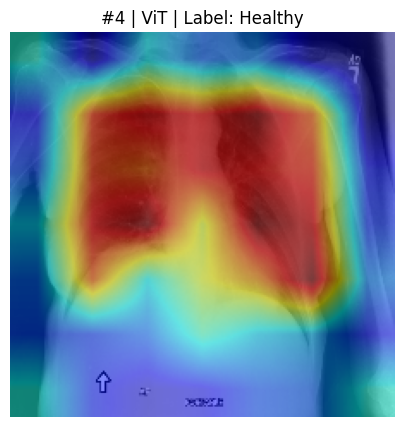

Processing sample #5


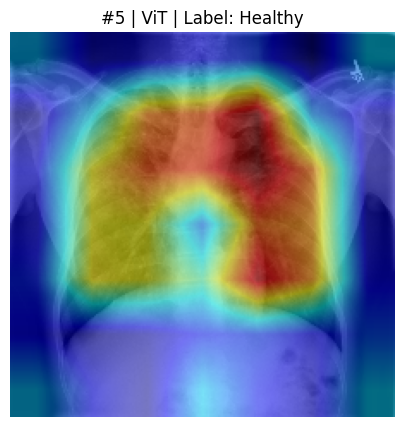

Processing sample #6


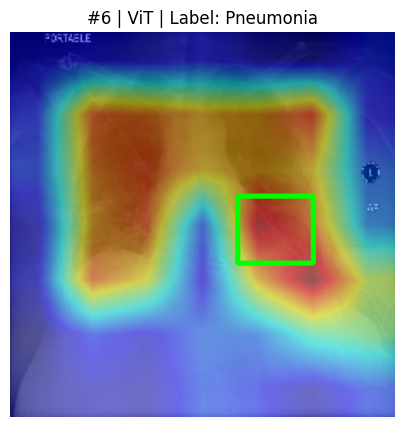

Processing sample #7


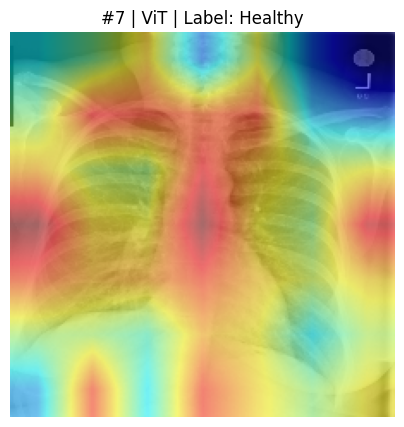

Processing sample #8


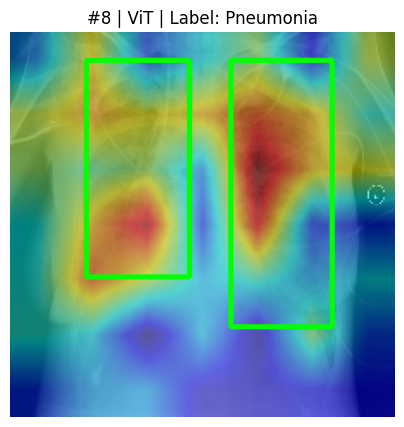

Processing sample #9


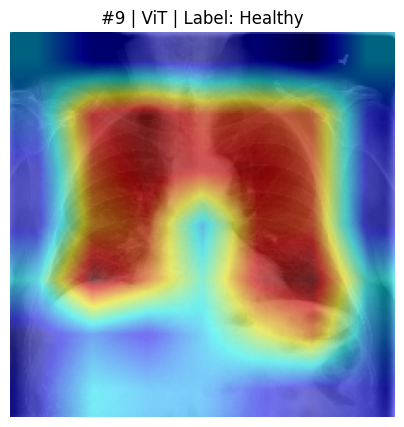

Processing sample #10


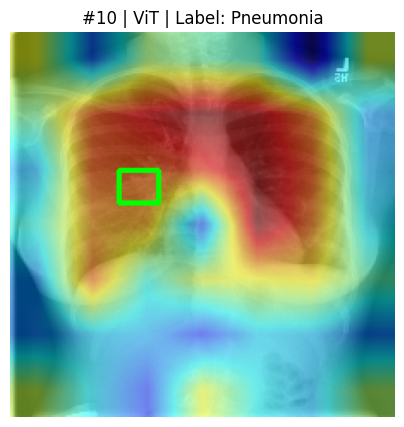

Processing sample #11


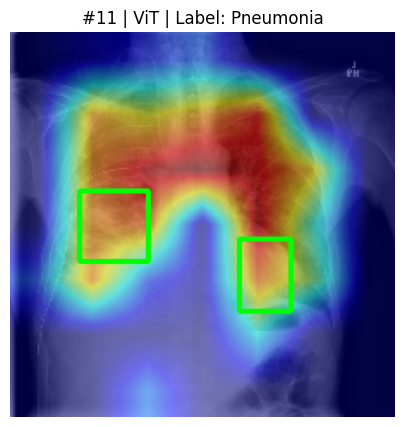

In [80]:
#run with normal ViT (unbalanced) on 10% of data (2667 samples in total)

checkpoint_path = "../MedCLIP/checkpoints/rsna_binary_classification_SU/final_model.bin"
plot_heatmaps(samples, checkpoint_path, "ViT")

Processing sample #0


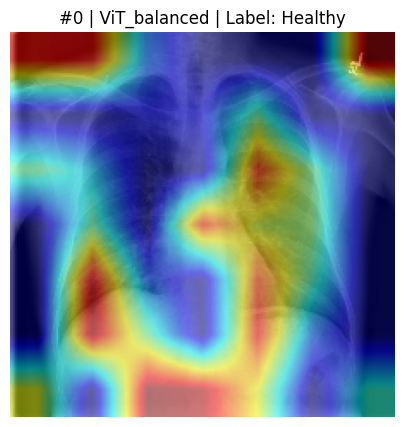

Processing sample #1


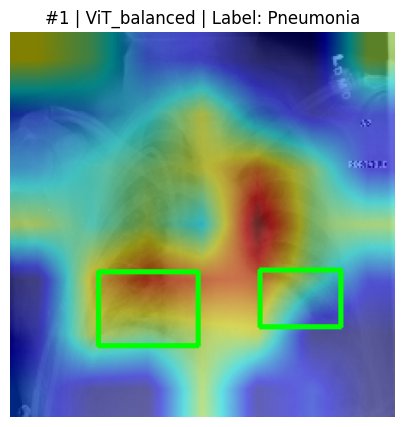

Processing sample #2


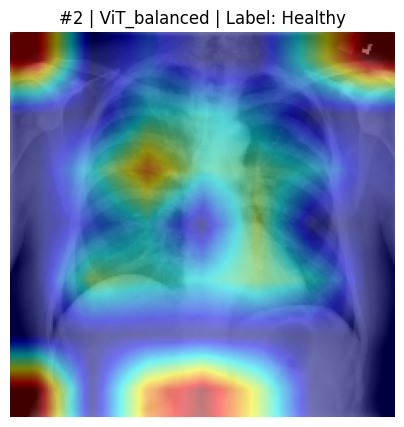

Processing sample #3


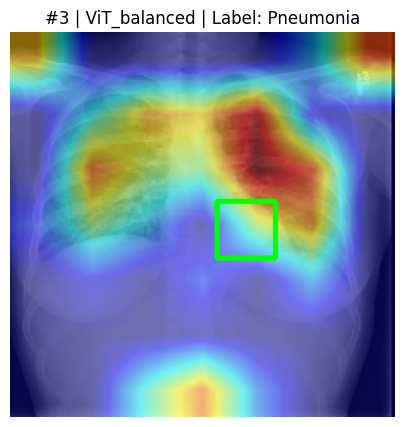

Processing sample #4


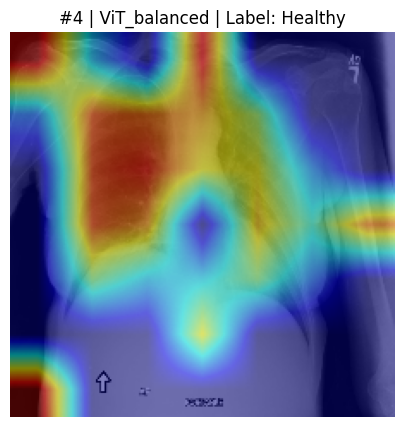

Processing sample #5


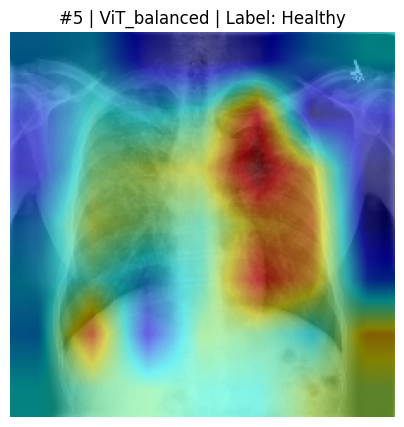

Processing sample #6


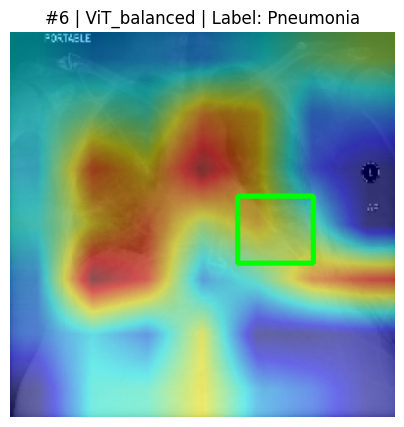

Processing sample #7


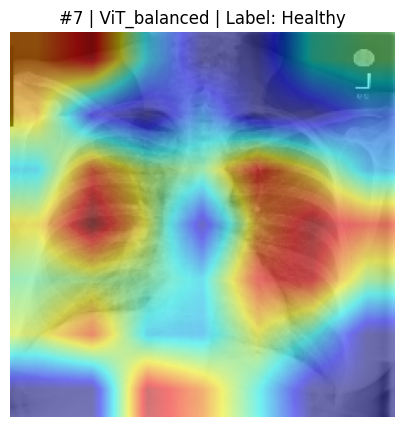

Processing sample #8


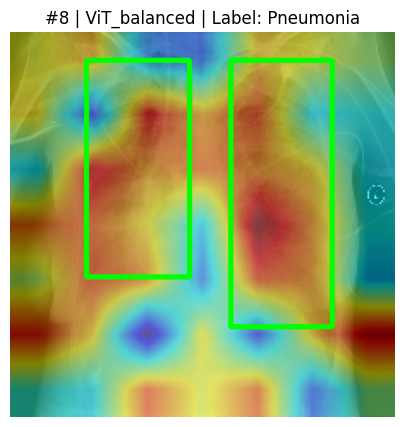

Processing sample #9


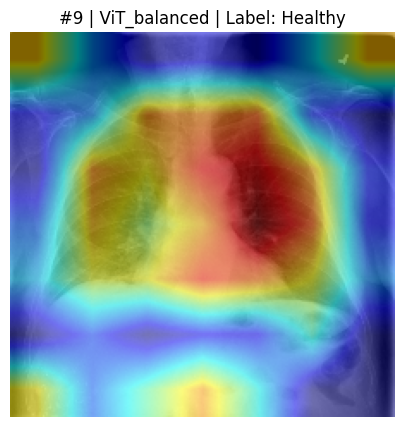

Processing sample #10


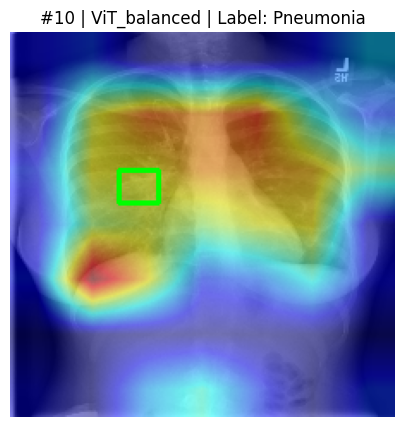

Processing sample #11


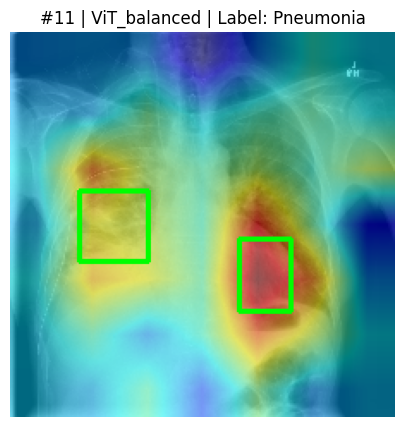

In [71]:
#run with normal ViT (balanced) on 20% of data (2666 samples in total)

checkpoint_path = "../MedCLIP/checkpoints/rsna_binary_classification_SU_balanced/final_model.bin"
plot_heatmaps(samples, checkpoint_path, "ViT_balanced")

Processing sample #0


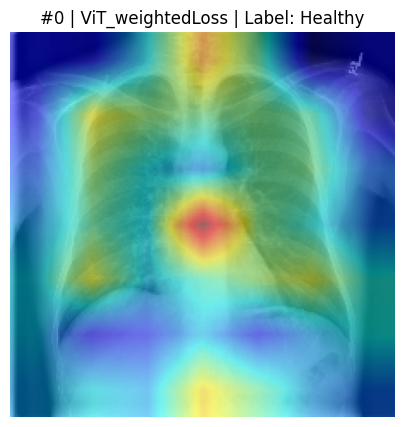

Processing sample #1


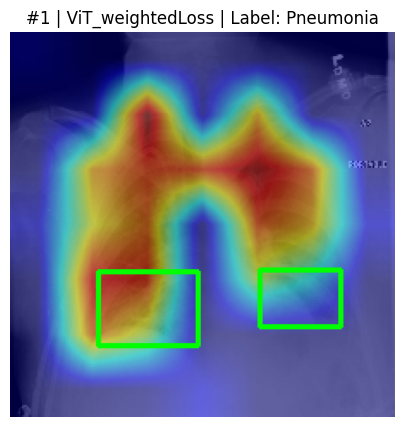

Processing sample #2


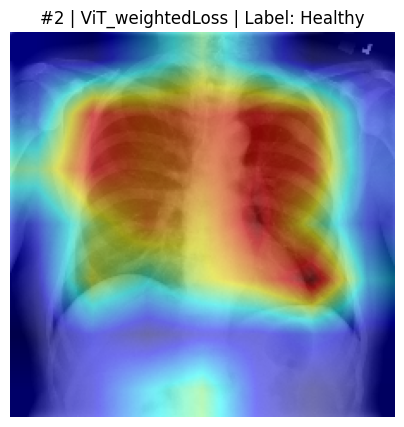

Processing sample #3


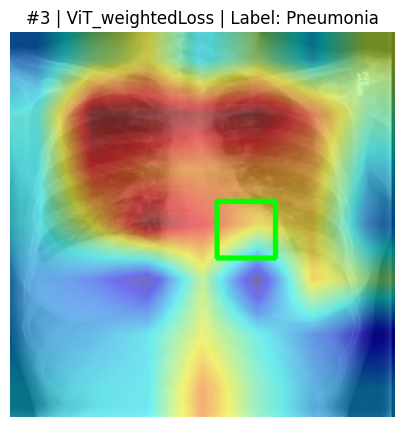

Processing sample #4


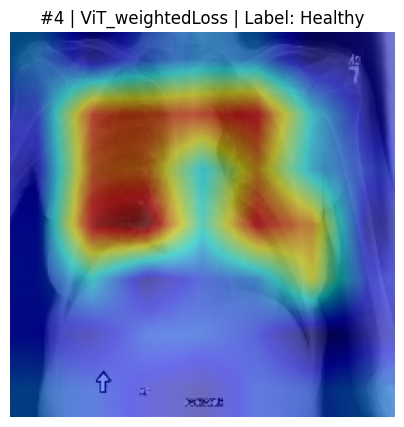

Processing sample #5


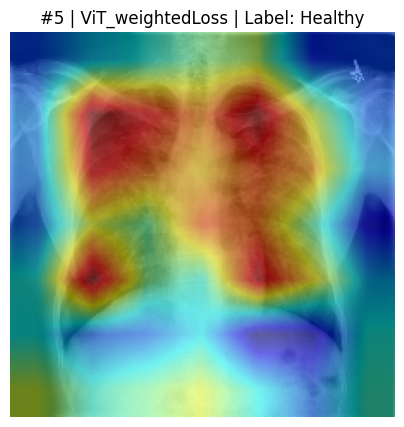

Processing sample #6


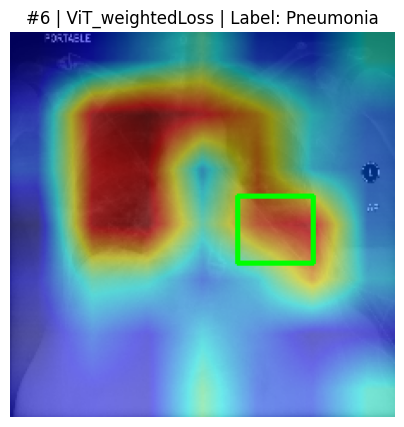

Processing sample #7


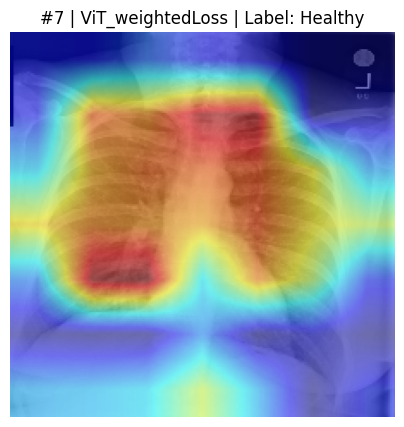

Processing sample #8


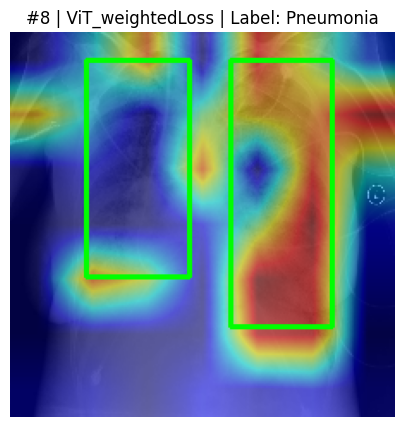

Processing sample #9


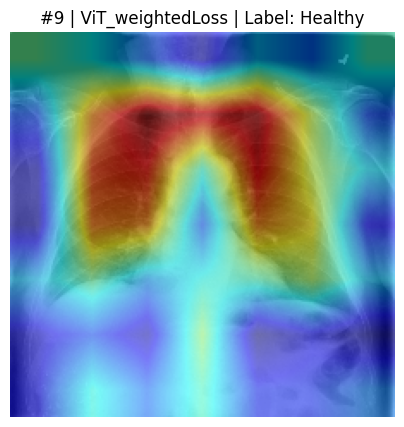

Processing sample #10


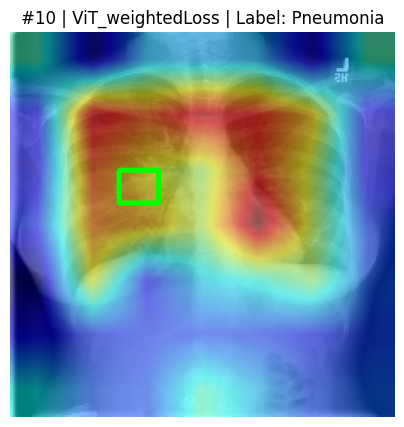

Processing sample #11


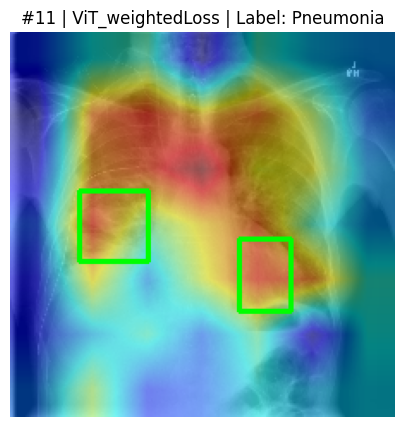

In [81]:
#run with normal ViT (unbalanced) on 10% of data with weighted loss (2667 samples in total)

checkpoint_path = "../MedCLIP/checkpoints/rsna_binary_classification_SU_weightedLoss/final_model.bin"
plot_heatmaps(samples, checkpoint_path, "ViT_weightedLoss")